#### Importar librerías y funciones necesarias

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind, binomtest
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from scipy.stats import wilcoxon

def test_normalitySW(data, variable):
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Normalidad Shapiro-Wilk para {variable}: estadístico = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")

def test_homogeneityL(var1, var2, name1, name2):
    levene_stat, levene_p = stats.levene(var1, var2)
    print(f"Levene entre {name1} y {name2}: estadístico = {levene_stat:.4f}, p = {levene_p:.4f}")

def t_test_two_sample(datos1, datos2):
    t_stat, p_value = ttest_ind(datos1, datos2)
    print(f"Prueba t para dos muestras: t = {t_stat:.4f}, p = {p_value:.4f}")

def U_Mann_W(datos1, datos2):
    stat, p_value = mannwhitneyu(datos1, datos2, alternative='two-sided')
    print(f"Mann-Whitney U: estadístico = {stat}, p = {p_value:.4f}")
    return p_value

def test_normalityKS(data, variable):
    print(f"\n Análisis de normalidad por Kolmogorov-Smirnov para '{variable}'")
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f" Estadístico = {ks_stat}, p-valor = {ks_p}")
    return ks_p

def box_cox(data):
    b, l = stats.boxcox(data)  
    print(f"Lambda Box–Cox = {l:.4f}\n")
    return b, l

def proportions(exitos, n, proportion, variable, direccion):  # Z-test
    print(f"\nPrueba de proporciones para {variable} (z-test)")
    stat, p_value = proportions_ztest(count=exitos, nobs=n, value=proportion, alternative=direccion)
    print(f"Estadístico z = {stat:.4f}, Valor_p = {p_value}")
    return stat, p_value

def binomial(exitos, k, prop, direccion):
    print(f"\nPrueba Binomial para {k} ensayos")
    result = binomtest(exitos, n=k, p=prop, alternative=direccion)
    print(f"Valor_p = {result.pvalue}")
    return result.pvalue
    
def verificarValorP(p_value, alfa):
    if p_value < alfa:
        print(f"**Rechazamos H0, aceptamos H1**")
    elif p_value > alfa:
        print(f"**Aceptamos H0, rechazamos H1**")

#### Leer datos

In [2]:
df = pd.read_csv("heart_attack_prediction_dataset.csv")

#  Inciso 1 — Colesterol promedio en quienes sufrieron infarto y en quienes no
H0: El valor promedio de colesterol de los pacientes que sufrieron infarto es mayor o igual a 200 mg/dL.

H1: El valor promedio de colesterol de los pacientes que sufrieron infarto es menor a 200 mg/dL.

Definimos alfa

In [3]:
alfa = 0.05

Leer datos de colesterol de pacientes con o sin riesgo de tener ataque cardíaco, eliminar NaN y obtener tamaño de muestra

In [4]:
conRiesgo = df.loc[df["Heart Attack Risk"]==1,  "Cholesterol"].dropna()
sinRiesgo = df.loc[df["Heart Attack Risk"]==0,  "Cholesterol"].dropna()

print("n =", conRiesgo.shape[0])
print("n =", sinRiesgo.shape[0])

n = 3139
n = 5624


Verificar supuestos con **prueba de normalidad** para hacer una prueba paramétrica (prueba t). Como n>50, usamos **Kolmogorov-Smirnoff**

In [5]:
verificarValorP(test_normalityKS(conRiesgo, "Colesterol con riesgo"), alfa)
verificarValorP(test_normalityKS(sinRiesgo, "Colesterol sin riesgo"), alfa)

NameError: name 'conRiesgo' is not defined

En la prueba de normalidad, rechazar H0 significa que **no son normales**. Procedemos a hacer transformaciones. Usaremos **Box-Cox** y volver a verificar normalidad.

In [6]:
b1, l1 = box_cox(conRiesgo)
b2, l2 = box_cox(sinRiesgo)

verificarValorP(test_normalityKS(b1, "Colesterol con riesgo (Box-Cox)"), alfa)
verificarValorP(test_normalityKS(b2, "Colesterol sin riesgo (Box-Cox)"), alfa)

Lambda Box–Cox = 0.8100

Lambda Box–Cox = 0.7268


 Análisis de normalidad por Kolmogorov-Smirnov para 'Colesterol con riesgo (Box-Cox)'
 Estadístico = 0.06334415133734983, p-valor = 2.1559254984622445e-11
**Rechazamos H0, aceptamos H1**

 Análisis de normalidad por Kolmogorov-Smirnov para 'Colesterol sin riesgo (Box-Cox)'
 Estadístico = 0.06012949613581342, p-valor = 4.057803529125847e-18
**Rechazamos H0, aceptamos H1**


Como siguen no siendo normales, graficamos para ver la dispersión de los datos.

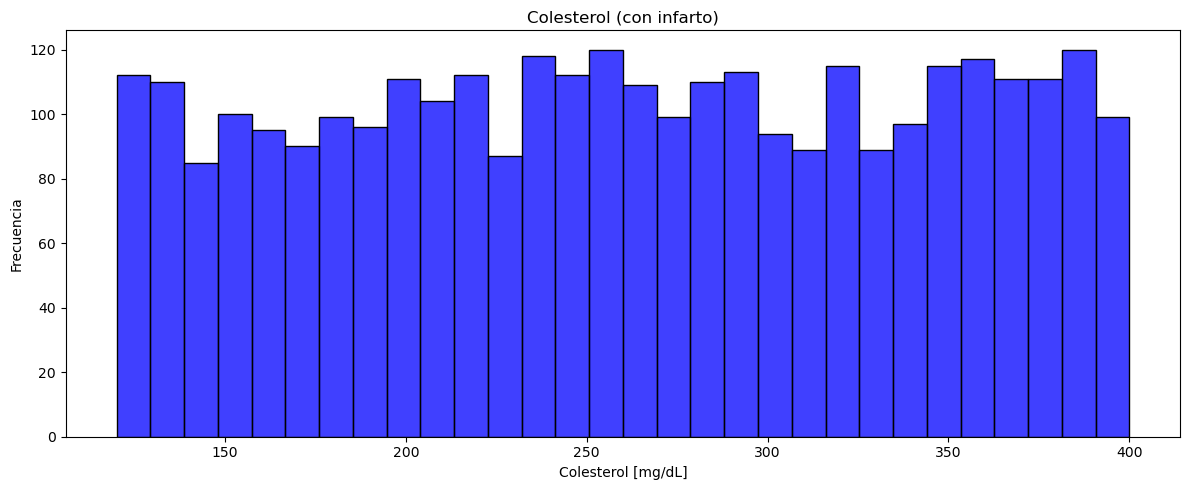

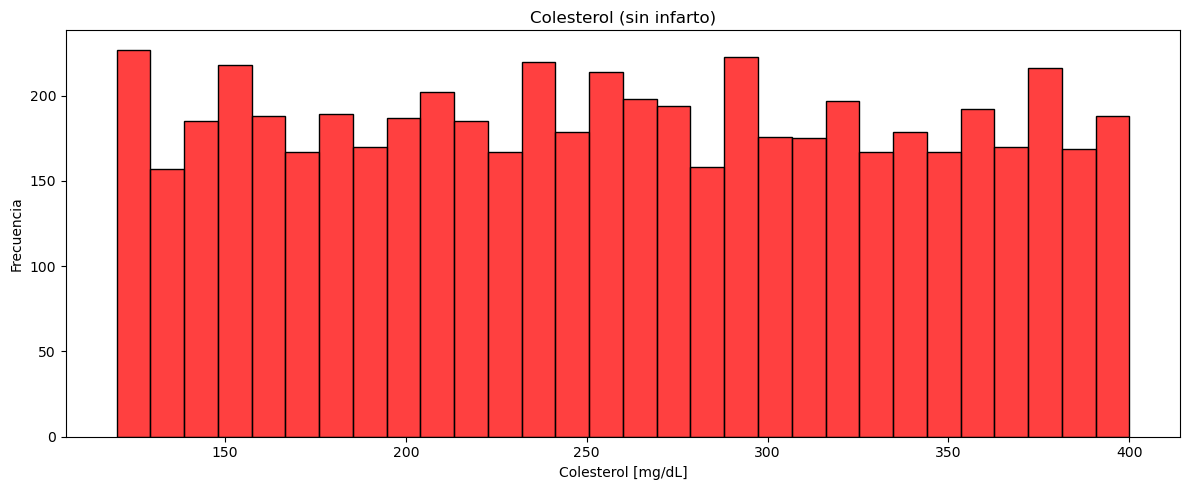

In [7]:
plt.figure(figsize=(12,5))
sns.histplot(conRiesgo, color="blue", bins=30)
plt.title(f"Colesterol (con infarto)")
plt.xlabel("Colesterol [mg/dL]")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.figure(figsize=(12,5))
sns.histplot(sinRiesgo, color="red", bins=30)
plt.title(f"Colesterol (sin infarto)")
plt.xlabel("Colesterol [mg/dL]")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Vemos en las gráficas que la dispersión de datos es muy homogénea, por lo que hacemos una prueba no paramétrica, **Wilcoxon**.

In [8]:
def wilcoxon_test (nombre, data,mediana=0,y=None, alt="two-sided"):
    
    stat, p_value = wilcoxon(data - mediana,y, alternative=alt)
    print(f"Prueba para: {nombre}. Estadístico de Wilcoxon: {stat:.4f}, p-valor: {p_value:.4f}")
    return p_value

verificarValorP(wilcoxon_test("Colesterol con infarto", conRiesgo, 200, None, "less"), alfa)
verificarValorP(wilcoxon_test("Colesterol sin infarto", sinRiesgo, 200, None, "less"), alfa)

Prueba para: Colesterol con infarto. Estadístico de Wilcoxon: 4116191.0000, p-valor: 1.0000
**Aceptamos H0, rechazamos H1**
Prueba para: Colesterol sin infarto. Estadístico de Wilcoxon: 13089110.0000, p-valor: 1.0000
**Aceptamos H0, rechazamos H1**


En la prueba Wilcoxon, aceptar H0 significa significa que **el valor promedio si es menor a 200ml/dL** con o sin infarto

# Inciso 2 — Diferencias de colesterol por edad (<50 vs ≥50)
H0: El prom de colesterol de los pacientes< de 50 años es igual al de los pacientes > de 50 años.

H1: El promedio de colesterol de los pacientes < de 50 años es diferente al de los pacientes >de 50 años.

In [5]:
colmenor50 = df.loc[df["Age"] <50, "Cholesterol"].dropna()
colmayor50 = df.loc[df["Age"] >50, "Cholesterol"].dropna()
print("n= ", colmenor50.shape[0])
print("n= ",colmayor50.shape[0])


n=  3928
n=  4707


Verificamos supuestos con **Pruebad de normalidad** para hacer una prueba paramétrica (prueba t para dos muestras). Como n>50, usamos **Kolmogorov-Smirnoff**

In [9]:
(test_normalityKS(colmenor50, "TAG pacientes >50 "), alfa)
verificarValorP(test_normalityKS(colmayor50, "TAG pacientes <50"), alfa)


 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG pacientes >50 '
 Estadístico = 0.06475692008708034, p-valor = 9.170426208633519e-15

 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG pacientes <50'
 Estadístico = 0.05388072953393497, p-valor = 2.5644764821373606e-12
**Rechazamos H0, aceptamos H1**


Al rechazar H0 los datos no son normales. Por lo que, realizamos transformaciones. Usamos **Box cox** y volvemos a verificar normalidad

In [10]:
b1, l1 = box_cox(colmayor50)
b2, l2 = box_cox(colmenor50)

verificarValorP(test_normalityKS(b1, "TAG pacientes > 50 (Box-Cox)"), alfa)
verificarValorP(test_normalityKS(b2, "TAG pacientes <50 (Box-Cox)"), alfa)

Lambda Box–Cox = 0.7669

Lambda Box–Cox = 0.7457


 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG pacientes > 50 (Box-Cox)'
 Estadístico = 0.05636180021410564, p-valor = 1.9433292181310467e-13
**Rechazamos H0, aceptamos H1**

 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG pacientes <50 (Box-Cox)'
 Estadístico = 0.06632318246307956, p-valor = 1.8203961787743185e-15
**Rechazamos H0, aceptamos H1**


Resultado: **Los datos no son normales** Por tanto, graficamos para observar su distribución

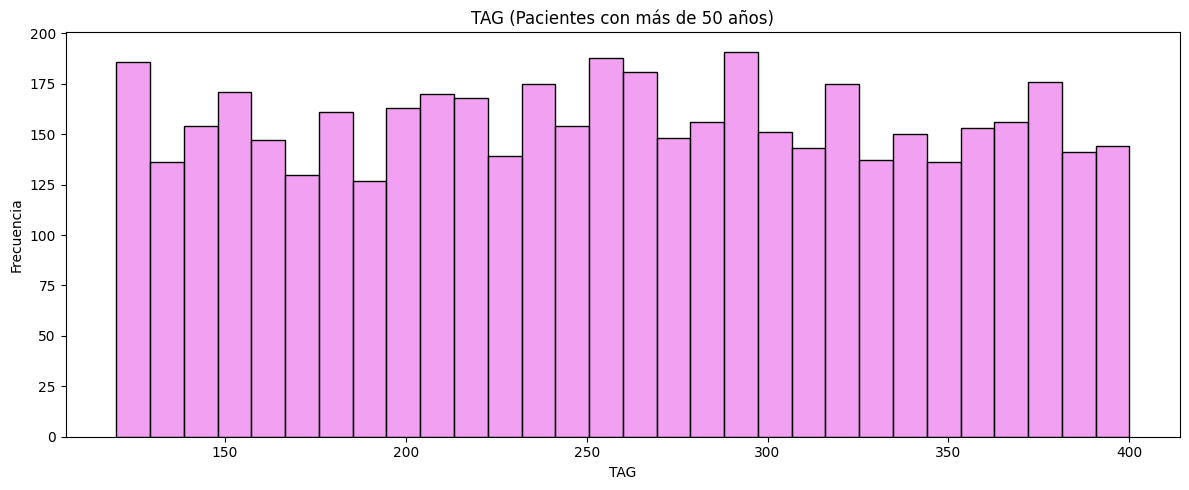

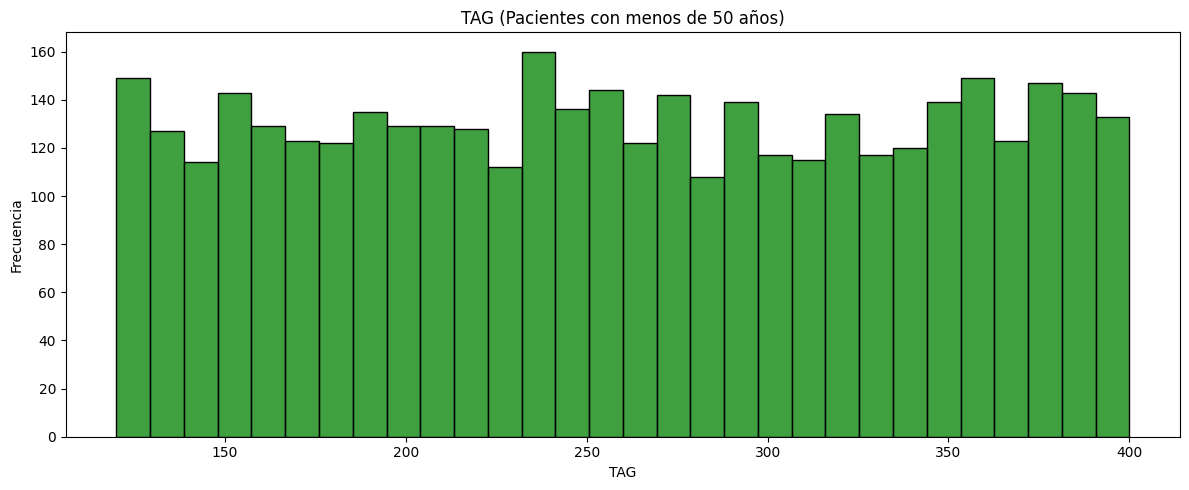

In [12]:
plt.figure(figsize=(12,5))
sns.histplot(colmayor50, color="violet", bins=30)
plt.title(f"TAG (Pacientes con más de 50 años)")
plt.xlabel("TAG")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.figure(figsize=(12,5))
sns.histplot(colmenor50, color="green", bins=30)
plt.title(f"TAG (Pacientes con menos de 50 años)")
plt.xlabel("TAG")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Resultado: Se presenta una distribución **homogenea** de los datos, por tanto realizamos una prueba no paramétrica, **U de Mann-Whitney**

In [13]:
verificarValorP(U_Mann_W(colmayor50, colmenor50), alfa)

Mann-Whitney U: estadístico = 9153648.0, p = 0.4307
**Aceptamos H0, rechazamos H1**


**Resultado**: Con la prueba de U de Mann-Whitney se acepta H0, lo que significa que el promedio de TAG en pacientes con más de 50 años es igual al de los pacientes con menos de 50 años.

# Inciso 3 — ¿Hay diferencia en el tiempo de ejercicio entre personas que sufrieron infarto y las que no?
H0: El promedio de horas de ejercicio semanal de los pacientes que sufrieron infarto es igual al de los pacientes que no sufrieron un infarto.

H1: El promedio de horas de ejercicio semanal de los pacientes que sufrieron infarto es diferente al de los pacientes que no sufrieron un infarto.

In [9]:
data = df[["Exercise Hours Per Week", "Heart Attack Risk"]].dropna()
data["Exercise Hours Per Week"] = pd.to_numeric(data["Exercise Hours Per Week"], errors="coerce")
data["Heart Attack Risk"] = pd.to_numeric(data["Heart Attack Risk"], errors="coerce")

# Separar grupos
ex_no  = data[data["Heart Attack Risk"] == 0]["Exercise Hours Per Week"].dropna()
ex_yes = data[data["Heart Attack Risk"] == 1]["Exercise Hours Per Week"].dropna()
print(f"N no-infarto: {len(ex_no)}, N infarto: {len(ex_yes)}")
print(f"No-infarto: media={ex_no.mean():.4f}, mediana={ex_no.median():.4f}")
print(f"Infarto:    media={ex_yes.mean():.4f}, mediana={ex_yes.median():.4f}")

N no-infarto: 5624, N infarto: 3139
No-infarto: media=9.9662, mediana=9.9142
Infarto:    media=10.1005, mediana=10.2921


In [10]:
p_no = test_normalityKS(ex_no, "No infarto (original)")
p_yes = test_normalityKS(ex_yes, "Infarto (original)")

# Aviso si no es normal
if p_no <= 0.05:
    print("No-infarto: distribución rara  hay que aplicar BoxCox")
else:
    print("No-infarto: distribución aprox. normal")

if p_yes <= 0.05:
    print("Infarto: distribución rara hay que aplicar BoxCox")
else:
    print("Infarto: distribución aprox. normal")


 Análisis de normalidad por Kolmogorov-Smirnov para 'No infarto (original)'
 Estadístico = 0.060444229974461416, p-valor = 2.645633343652403e-18

 Análisis de normalidad por Kolmogorov-Smirnov para 'Infarto (original)'
 Estadístico = 0.06307739541623741, p-valor = 2.6657304139880403e-11
No-infarto: distribución rara  hay que aplicar BoxCox
Infarto: distribución rara hay que aplicar BoxCox


In [11]:
u = False
lam_no = lam_yes = None

if p_no <= 0.05:
    ex_no, lam_no = box_cox(ex_no)
    print("Box–Cox aplicado a No-infarto")
    p_no = test_normalityKS(ex_no, "No infarto (Box–Cox)")
    u = True

if p_yes <= 0.05:
    ex_yes, lam_yes = box_cox(ex_yes)
    print("Box–Cox aplicado a Infarto")
    p_yes = test_normalityKS(ex_yes, "Infarto (Box–Cox)")
    u = True

Lambda Box–Cox = 0.7051

Box–Cox aplicado a No-infarto

 Análisis de normalidad por Kolmogorov-Smirnov para 'No infarto (Box–Cox)'
 Estadístico = 0.06505455843274899, p-valor = 3.890007312829406e-21
Lambda Box–Cox = 0.7231

Box–Cox aplicado a Infarto

 Análisis de normalidad por Kolmogorov-Smirnov para 'Infarto (Box–Cox)'
 Estadístico = 0.07301839697499835, p-valor = 5.330483340504595e-15


In [12]:
lev_p = test_homogeneityL(ex_no, ex_yes, "No-infarto", "Infarto")
print("Si p > 0.05 significa que las varianzas son similares; si p <= 0.05 significa que las varianzas son diferentes\n")

Levene entre No-infarto y Infarto: estadístico = 10.9774, p = 0.0009
Si p > 0.05 significa que las varianzas son similares; si p <= 0.05 significa que las varianzas son diferentes



In [13]:
if p_no > 0.05 and p_yes > 0.05:
    # Si Ambos grupos normales, revisamos varianzas
    lev_stat, lev_p = stats.levene(ex_no, ex_yes)
    if lev_p > 0.05:
        t_test_two_sample(ex_no, ex_yes)
    else:
        print("Varianzas diferentes usar Mann-Whitney U")
        final_p = U_Mann_W(ex_no, ex_yes)
else:
    final_p = U_Mann_W(ex_no, ex_yes)
if final_p < 0.05:
    print(f"Diferencia significativa entre grupos (p={final_p:.4f}) → rechazar H0")
    print(" -----Implica que la cantidad de horas de ejercicio difiere entre quienes tuvieron infarto y quienes no.")
else:
    print(f"No hay evidencia de diferencia entre grupos (p={final_p:.4f}) → no rechazar H0")
    print("  -----Implica que no se encontro evidencia estadistica de que las horas de ejercicio sean distintas entre los grupos.")


Mann-Whitney U: estadístico = 8411981.0, p = 0.0003
Diferencia significativa entre grupos (p=0.0003) → rechazar H0
 -----Implica que la cantidad de horas de ejercicio difiere entre quienes tuvieron infarto y quienes no.


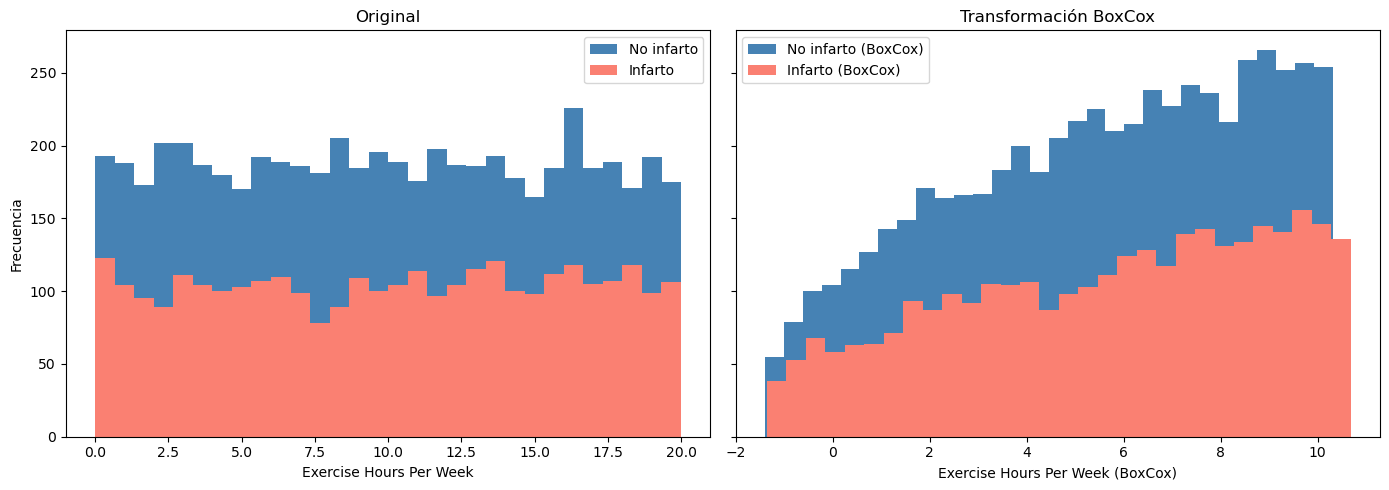

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
axes[0].hist(data.loc[data["Heart Attack Risk"]==0, "Exercise Hours Per Week"],color="steelblue",
             bins=30 , label="No infarto")
axes[0].hist(data.loc[data["Heart Attack Risk"]==1, "Exercise Hours Per Week"], color="salmon",
             bins=30, label="Infarto")
axes[0].set_title("Original")
axes[0].set_xlabel("Exercise Hours Per Week")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()
if u:
    axes[1].hist(ex_no, bins=30, label="No infarto (BoxCox)",color="steelblue")
    axes[1].hist(ex_yes, bins=30, label="Infarto (BoxCox)",color="salmon")
    axes[1].set_title("Transformación BoxCox")
    axes[1].set_xlabel("Exercise Hours Per Week (BoxCox)")
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, "No se aplicó BoxCox", ha='center', va='center')
    axes[1].set_title("BoxCox")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()


### Comparación de histogramas

- **Original:** muestra la distribución real de horas de ejercicio en ambos grupos.
  - Se observa que los datos son “raros”, no siguen una normal.
- **Box–Cox aplicada:** aunque se aplica la transformación, la distribución sigue viéndose rara.
  - Box–Cox ayuda a ajustar, pero no garantiza normalidad perfecta.
- Esto explica por qué es necesario usar pruebas no paramétricas (Mann-Whitney) para comparar los grupos.


# Inciso 4 — Diferencias en triglicéridos entre obesos y no obesos
H0: El promedio de TAG en pacientes obesos es igual al de los pacientes no obesos

H1 El promedio de TAG  en pacientes obesos es diferente al de los pacientes no obesos

Leer datos de TAG de pacientes obesos y no obesos, eliminar NaN y obtener tamaño de muestra

In [15]:
obeso = df.loc[df["Obesity"]==1,  "Triglycerides"].dropna()
noObseso = df.loc[df["Obesity"]==0,  "Triglycerides"].dropna()

print("n =", conRiesgo.shape[0])
print("n =", sinRiesgo.shape[0])

n = 3139
n = 5624


Verificar supuestos con **prueba de normalidad** para hacer una prueba paramétrica (prueba t para 2 muestras). Como n>50, usamos **Kolmogorov-Smirnoff**

In [16]:
(test_normalityKS(obeso, "TAverificarValorPG obesos"), alfa)
verificarValorP(test_normalityKS(noObseso, "TAG no obesos"), alfa)


 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG obesos'
 Estadístico = 0.05981382347515263, p-valor = 4.158674541894702e-14
**Rechazamos H0, aceptamos H1**

 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG no obesos'
 Estadístico = 0.06244129690333011, p-valor = 2.9852340520778808e-15
**Rechazamos H0, aceptamos H1**


Rechazar H0 significa que **no son normales**. Procedemos a hacer transformaciones. Usaremos **Box-Cox** y volver a verificar normalidad.

In [17]:
b1, l1 = box_cox(obeso)
b2, l2 = box_cox(noObseso)

verificarValorP(test_normalityKS(b1, "TAG obesos (Box-Cox)"), alfa)
verificarValorP(test_normalityKS(b2, "TAG no obesos (Box-Cox)"), alfa)

Lambda Box–Cox = 0.7363

Lambda Box–Cox = 0.7310


 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG obesos (Box-Cox)'
 Estadístico = 0.0641297747442171, p-valor = 3.7383870285409956e-16
**Rechazamos H0, aceptamos H1**

 Análisis de normalidad por Kolmogorov-Smirnov para 'TAG no obesos (Box-Cox)'
 Estadístico = 0.06609554490847824, p-valor = 4.87812109258785e-17
**Rechazamos H0, aceptamos H1**


Como siguen no siendo normales, graficamos.

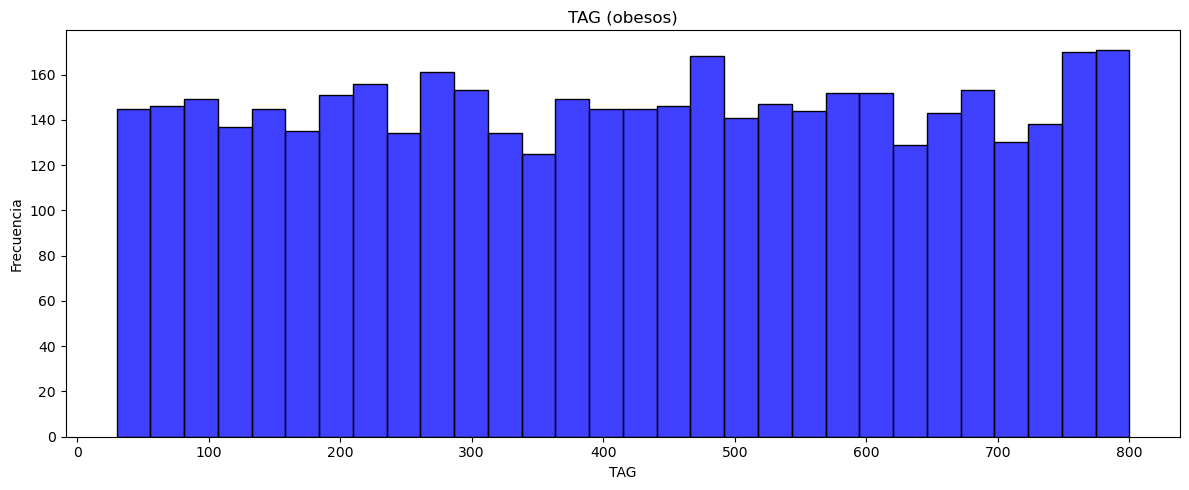

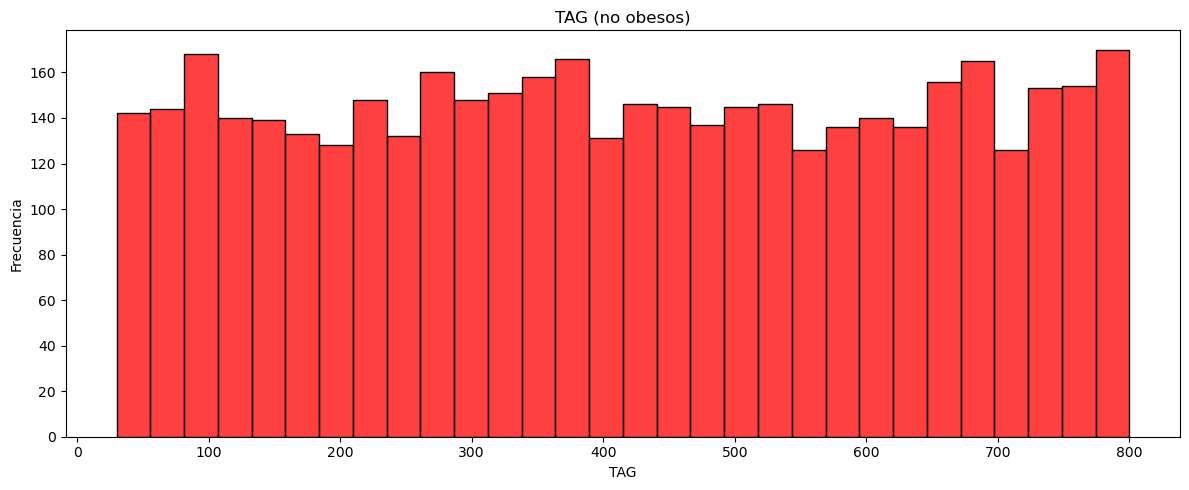

In [18]:
plt.figure(figsize=(12,5))
sns.histplot(obeso, color="blue", bins=30)
plt.title(f"TAG (obesos)")
plt.xlabel("TAG")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.figure(figsize=(12,5))
sns.histplot(noObseso, color="red", bins=30)
plt.title(f"TAG (no obesos)")
plt.xlabel("TAG")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

La dispersión de datos es muy homogénea, por lo que hacemos una prueba no paramétrica, **U de Mann-Whitney**.

In [19]:
verificarValorP(U_Mann_W(obeso, noObseso), alfa)

Mann-Whitney U: estadístico = 9615385.5, p = 0.8879
**Aceptamos H0, rechazamos H1**


En la prueba U de Mann-Whitney, aceptar H0 significa significa que **el promedio de TAG en pacientes obesos es igual al de los pacientes no obesos** 

# Inciso 5 — Proporción de personas con diabetes entre quienes tuvieron infarto vs 30%
H0 La proporcion de pacientes diabéticos con infarto en el estudio es igual al 30% reportado a nivel mundial.

H1 La proporcion de pacientes diabéticos con infarto en el estudio es diferente al 30% reportado a nivel mundial.

In [20]:
diabet = df.loc[df["Heart Attack Risk"]==1, "Diabetes"].dropna()
ele = len(diabet) # Numero total 
c = diabet.sum() # Personas con diabetes. Como los valores son 0 y 1, la suma es como a contar cuantos 1 hay
prop_observada = c / ele
print(f"Grupo infartados: {ele} personas con datos de diabetes\n")
print(f"Personas con diabetes: {c} ({prop_observada:.2%})\n")
p0 = 0.3  # 30%
print(f"Proporción de referencia: {p0:.0%}\n")


Grupo infartados: 3139 personas con datos de diabetes

Personas con diabetes: 2082 (66.33%)

Proporción de referencia: 30%



In [21]:
e_pos = ele * p0
e_neg = ele * (1 - p0)
print("Verificando supuestos del z-test para proporciones:")
print(f"- Valor esperado positivos (diabetes) = {e_pos:.2f}")
print(f"- Valor esperado negativos (no diabetes) = {e_neg:.2f}")

if e_pos >= 5 and e_neg >= 5:
    print("El tamaño es suficiente  para usar z-test")
    stat, pval = proportions(c, ele, p0, "Diabetes entre infartados", "two-sided")
else:
    print("Tamaño insuficiente hay que usar la prueba binomial exacta (no parametrica)")
    pval = binomial(c, ele, p0, "two-sided")
print("\nConclusión:")
if pval < 0.05:
    print("La proporción de diabetes en infartados difiere significativamente de 30% por lo tanto se rechaza H0")
    print(f"   Esto indica que en este grupo la diabetes es {"más frecuente" if prop_observada>p0 else "menos frecuente"} entre los infartados que el valor de referencia del 30%.")
else:
    print("No hay evidencia de diferencia respecto al 30% por lo tanto se rechaza H1")
    print("-----Esto sugiere que la proporción de diabetes entre infartados podría ser cercana al 30%, según los datos disponibles.")

Verificando supuestos del z-test para proporciones:
- Valor esperado positivos (diabetes) = 941.70
- Valor esperado negativos (no diabetes) = 2197.30
El tamaño es suficiente  para usar z-test

Prueba de proporciones para Diabetes entre infartados (z-test)
Estadístico z = 43.0662, Valor_p = 0.0

Conclusión:
La proporción de diabetes en infartados difiere significativamente de 30% por lo tanto se rechaza H0
   Esto indica que en este grupo la diabetes es más frecuente entre los infartados que el valor de referencia del 30%.


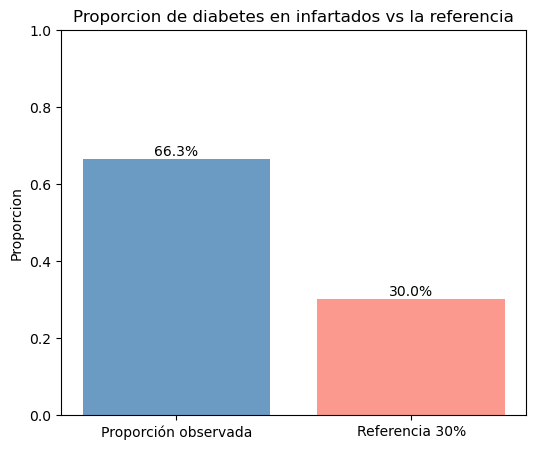

In [22]:
v = [prop_observada, p0]
eti = ["Proporción observada", "Referencia 30%"]

# Crear figura
plt.figure(figsize=(6,5))
jos = plt.bar(eti, v, color=["steelblue", "salmon"], alpha=0.8)
for jo in jos:
    h = jo.get_height()
    plt.text(jo.get_x() + jo.get_width()/2, h + 0.01, f"{h:.1%}", ha='center')

plt.ylim(0, 1)
plt.ylabel("Proporcion")
plt.title("Proporcion de diabetes en infartados vs la referencia")
plt.show()